In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- CORREÇÃO DOS IMPORTS (Para sumir os avisos amarelos) ---
import tensorflow as tf
import keras # Importa o Keras separadamente
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Configurações Globais
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 30 # Se estiver muito lento, mude para 10 ou 15
LEARNING_RATE = 0.001
base_dir = './dogs_vs_cats'


In [3]:
import os
from PIL import Image

def limpar_imagens_corrompidas(folder_path):
    print(f"--- Verificando imagens em: {folder_path} ---")
    deleted_files = 0
    
    # Percorre todas as pastas e subpastas
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            file_path = os.path.join(root, filename)
            
            try:
                # Tenta abrir a imagem
                with Image.open(file_path) as img:
                    img.verify() # Verifica a integridade do arquivo
            except (IOError, SyntaxError, Image.UnidentifiedImageError) as e:
                # Se der erro, deleta o arquivo
                print(f"Arquivo corrompido removido: {filename}")
                os.remove(file_path)
                deleted_files += 1

    if deleted_files == 0:
        print("Nenhuma imagem corrompida encontrada.")
    else:
        print(f"Total de arquivos removidos: {deleted_files}")

# Chama a função na sua pasta base
# Certifique-se que a variável 'base_dir' está definida como na Célula anterior
limpar_imagens_corrompidas(base_dir)

--- Verificando imagens em: ./dogs_vs_cats ---
Arquivo corrompido removido: 666.jpg
Arquivo corrompido removido: Thumbs.db
Arquivo corrompido removido: 11702.jpg


C:\Users\otavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Arquivo corrompido removido: Thumbs.db
Total de arquivos removidos: 4


In [4]:

print(f"Lendo imagens de: {os.path.abspath(base_dir)}")

# --- Configuração dos Geradores com Separação Automática ---

# Definimos o Data Augmentation E a divisão de validação (20%) aqui
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalização
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2         # <--- ISSO É NOVO: Separa 20% para teste automaticamente
)

# Gerador de Treino (usa 80% dos dados)
train_generator = train_datagen.flow_from_directory(
    base_dir,                    # Aponta para a pasta dogs_vs_cats
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'            # <--- Pega apenas a parte de treino
)

# Gerador de Teste/Validação (usa 20% dos dados)
test_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,               # Importante manter False para a Matriz de Confusão
    subset='validation'          # <--- Pega apenas a parte de validação
)

Lendo imagens de: c:\Users\otavi\Faculdade\IA\Listas\Lista Extra\dogs_vs_cats
Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [5]:
# Célula 5: Definição da Arquitetura do Modelo

model = Sequential([
    # Primeiro Bloco Convolucional
    Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SIZE + (3,)), # (150, 150, 3)
    MaxPooling2D(2, 2),

    # Segundo Bloco Convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Terceiro Bloco Convolucional
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Quarto Bloco Convolucional (Opcional, para mais complexidade)
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Camada Flatten para converter matrizes 2D em vetor 1D
    Flatten(),

    # Camada Densa (Fully Connected)
    Dense(512, activation='relu'),
    Dropout(0.5), # Desliga 50% dos neurônios aleatoriamente para evitar overfitting

    # Camada de Saída (BINÁRIA: 1 neurônio, sigmoid)
    Dense(1, activation='sigmoid')
])

# Compilação do Modelo
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy', # Obrigatório para classificação binária (0 ou 1)
    metrics=['accuracy']
)

model.summary()

C:\Users\otavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Célula 6: Treinamento com Callbacks

# Callbacks para melhorar o treinamento
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
]

print("Iniciando treinamento...")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE, # Garante que passe por todas as imagens
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)

print("Treinamento concluído.")

Iniciando treinamento...
Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 150s 237ms/step - accuracy: 0.5479 - loss: 0.6859 - val_accuracy: 0.5655 - val_loss: 0.6825 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 170s 273ms/step - accuracy: 0.6151 - loss: 0.6547 - val_accuracy: 0.6677 - val_loss: 0.6158 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 182s 291ms/step - accuracy: 0.6768 - loss: 0.6002 - val_accuracy: 0.7165 - val_loss: 0.5510 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 176s 282ms/step - accuracy: 0.7191 - loss: 0.5539 - val_accuracy: 0.7502 - val_loss: 0.5038 - learning_rate: 0.0010
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 163s 261ms/step - accuracy: 0.7423 - loss: 0.5234 - val_accuracy: 0.7738 - val_loss: 0.4895 - learning_rate: 0.0010
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 163s 260ms/step - accuracy: 0.7700 - loss: 0.4873 - val_accuracy: 0.7698 - val_loss: 0.4859 - learning_rate: 0.0010
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━

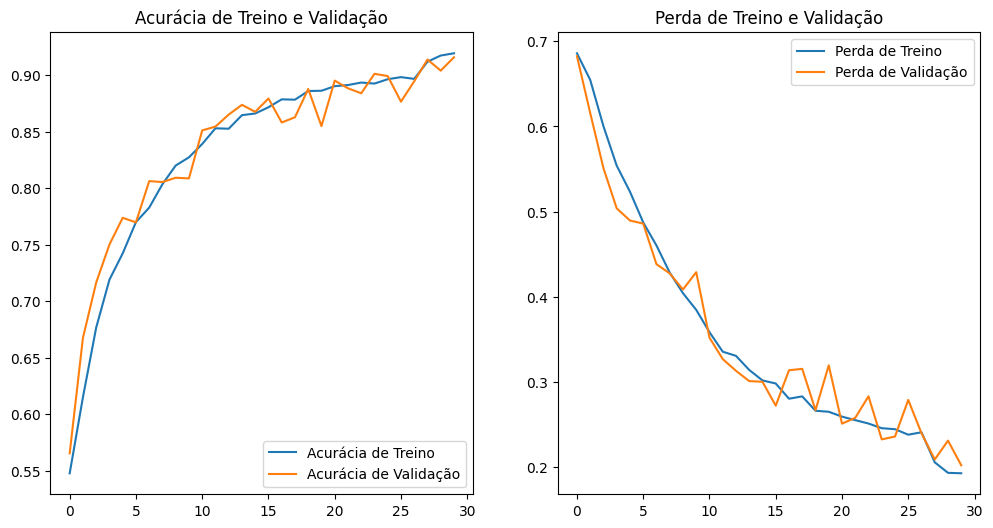

In [7]:
# Célula 7: Plotagem dos Gráficos de Desempenho

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Gráfico de Acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')

# Gráfico de Perda (Loss)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treino')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treino e Validação')

plt.show()

Gerando previsões...
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step


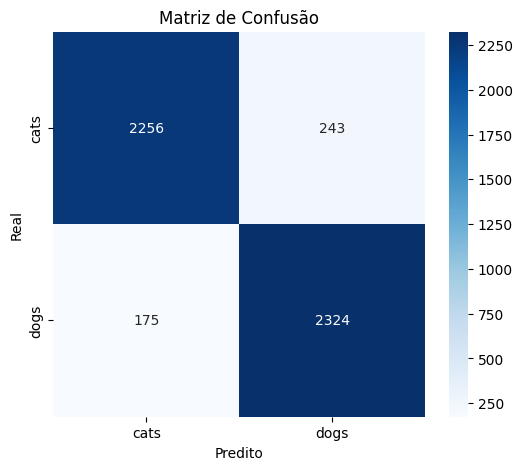


Relatório de Classificação:

              precision    recall  f1-score   support

        cats       0.93      0.90      0.92      2499
        dogs       0.91      0.93      0.92      2499

    accuracy                           0.92      4998
   macro avg       0.92      0.92      0.92      4998
weighted avg       0.92      0.92      0.92      4998



In [8]:
# Célula 8: Matriz de Confusão e Relatório de Classificação

# 1. Gerar previsões para o conjunto de teste/validação
print("Gerando previsões...")
predictions = model.predict(test_generator)

# 2. Converter probabilidades em classes (0 ou 1)
# Se probabilidade > 0.5 é Cachorro (1), senão é Gato (0)
y_pred = (predictions > 0.5).astype(int).ravel()

# 3. Pegar as classes reais (Ground Truth)
y_true = test_generator.classes

# 4. Pegar os nomes das classes (ex: 'cat', 'dog')
class_names = list(test_generator.class_indices.keys())

# --- Matriz de Confusão ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# --- Relatório Completo ---
print("\nRelatório de Classificação:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

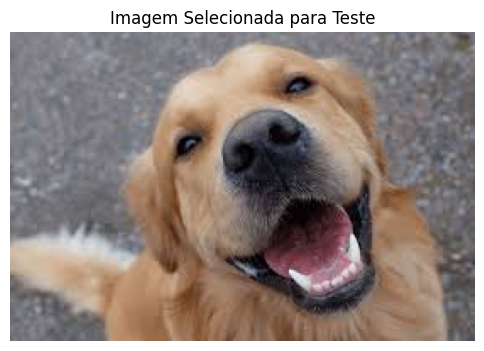

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

--- Resultado da Classificação ---
🐶 É um CACHORRO! (Certeza: 100.00%)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# --- CONFIGURAÇÃO ---
nome_da_imagem = 'image1.png'  

try:
    # 1. Carregar e exibir a imagem original para visualização
    img_show = plt.imread(nome_da_imagem)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_show)
    plt.axis('off')
    plt.title("Imagem Selecionada para Teste")
    plt.show()

    # 2. Pré-processamento (Obrigatório ser igual ao treinamento)
    # Redimensiona para 150x150
    img = image.load_img(nome_da_imagem, target_size=(150, 150))
    
    # Converte para Array Numpy
    x = image.img_to_array(img)
    
    # Adiciona uma dimensão extra para virar um "lote" de 1 imagem: (1, 150, 150, 3)
    x = np.expand_dims(x, axis=0)
    
    # Normaliza os pixels (escala de 0 a 1), igual fizemos no treino
    x = x / 255.0

    # 3. Fazendo a Previsão
    prediction = model.predict(x)
    probabilidade = prediction[0][0] # Pega o valor único dentro do array

    # 4. Interpretando o resultado
    # O modelo aprendeu que 0 = Gato e 1 = Cachorro (ordem alfabética das pastas)
    print("\n--- Resultado da Classificação ---")
    if probabilidade > 0.5:
        certeza = probabilidade * 100
        print(f"🐶 É um CACHORRO! (Certeza: {certeza:.2f}%)")
    else:
        certeza = (1 - probabilidade) * 100
        print(f"🐱 É um GATO! (Certeza: {certeza:.2f}%)")

except FileNotFoundError:
    print(f"ERRO: O arquivo '{nome_da_imagem}' não foi encontrado.")
    print("Verifique se o nome está correto e se a imagem está na mesma pasta do Notebook.")

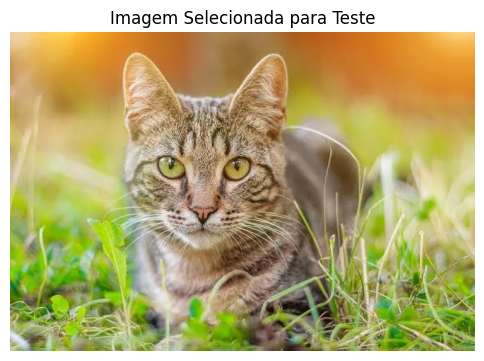

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

--- Resultado da Classificação ---
🐱 É um GATO! (Certeza: 99.72%)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# --- CONFIGURAÇÃO ---
nome_da_imagem = 'image2.png'  

try:
    # 1. Carregar e exibir a imagem original para visualização
    img_show = plt.imread(nome_da_imagem)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_show)
    plt.axis('off')
    plt.title("Imagem Selecionada para Teste")
    plt.show()

    # 2. Pré-processamento (Obrigatório ser igual ao treinamento)
    # Redimensiona para 150x150
    img = image.load_img(nome_da_imagem, target_size=(150, 150))
    
    # Converte para Array Numpy
    x = image.img_to_array(img)
    
    # Adiciona uma dimensão extra para virar um "lote" de 1 imagem: (1, 150, 150, 3)
    x = np.expand_dims(x, axis=0)
    
    # Normaliza os pixels (escala de 0 a 1), igual fizemos no treino
    x = x / 255.0

    # 3. Fazendo a Previsão
    prediction = model.predict(x)
    probabilidade = prediction[0][0] # Pega o valor único dentro do array

    # 4. Interpretando o resultado
    # O modelo aprendeu que 0 = Gato e 1 = Cachorro (ordem alfabética das pastas)
    print("\n--- Resultado da Classificação ---")
    if probabilidade > 0.5:
        certeza = probabilidade * 100
        print(f"🐶 É um CACHORRO! (Certeza: {certeza:.2f}%)")
    else:
        certeza = (1 - probabilidade) * 100
        print(f"🐱 É um GATO! (Certeza: {certeza:.2f}%)")

except FileNotFoundError:
    print(f"ERRO: O arquivo '{nome_da_imagem}' não foi encontrado.")
    print("Verifique se o nome está correto e se a imagem está na mesma pasta do Notebook.")

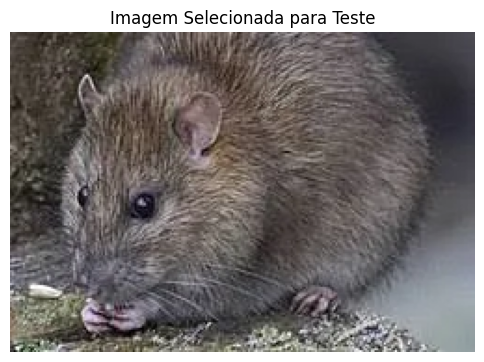

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

--- Resultado da Classificação ---
🐱 É um GATO! (Certeza: 68.45%)


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# --- CONFIGURAÇÃO ---
nome_da_imagem = 'image3.png'  

try:
    # 1. Carregar e exibir a imagem original para visualização
    img_show = plt.imread(nome_da_imagem)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_show)
    plt.axis('off')
    plt.title("Imagem Selecionada para Teste")
    plt.show()

    # 2. Pré-processamento (Obrigatório ser igual ao treinamento)
    # Redimensiona para 150x150
    img = image.load_img(nome_da_imagem, target_size=(150, 150))
    
    # Converte para Array Numpy
    x = image.img_to_array(img)
    
    # Adiciona uma dimensão extra para virar um "lote" de 1 imagem: (1, 150, 150, 3)
    x = np.expand_dims(x, axis=0)
    
    # Normaliza os pixels (escala de 0 a 1), igual fizemos no treino
    x = x / 255.0

    # 3. Fazendo a Previsão
    prediction = model.predict(x)
    probabilidade = prediction[0][0] # Pega o valor único dentro do array

    # 4. Interpretando o resultado
    # O modelo aprendeu que 0 = Gato e 1 = Cachorro (ordem alfabética das pastas)
    print("\n--- Resultado da Classificação ---")
    if probabilidade > 0.5:
        certeza = probabilidade * 100
        print(f"🐶 É um CACHORRO! (Certeza: {certeza:.2f}%)")
    else:
        certeza = (1 - probabilidade) * 100
        print(f"🐱 É um GATO! (Certeza: {certeza:.2f}%)")

except FileNotFoundError:
    print(f"ERRO: O arquivo '{nome_da_imagem}' não foi encontrado.")
    print("Verifique se o nome está correto e se a imagem está na mesma pasta do Notebook.")